In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import os
import numpy as np
import torch
from models import Generator, SpeakerRecognitionModel

In [2]:
torch.no_grad()

In [3]:
# load GAN generator
gan_path = '/home/adlr_video_prediction.cosmos361/tts/runs/asrgen/speaker101/run_0_noother/checkpoint_dcgan_speaker101_beta0_clr0.0001_grl0.0001_3000'
G_net = Generator(64)
G_net.load_state_dict(torch.load(gan_path, map_location='cpu')['G_net'])

In [4]:
# load Speaker Recognition
sr_path = 'sr_model.pt'
N_CLASSES = 102
SR_model = SpeakerRecognitionModel(N_CLASSES)
SR_model.load_state_dict(torch.load(sr_path, map_location='cpu')['model'])

In [5]:
G_net.cuda()

Generator(
  (preprocess): Linear(in_features=128, out_features=8192, bias=True)
  (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (block1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (block3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (deconv_out): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)

In [6]:
SR_model.cuda()

SpeakerRecognitionModel(
  (convs): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linears): Sequential(
    (0): Linear(in_features=16384, out_features=2048, bias=True)
    (1): Dropout(p=0.5)
    (2): Linear(in_features=2048, out_features=102, bias=True)
  )
)

In [7]:
SPEAKER_ID = 101
N_ATTACKS = 100
SAMPLES_PER_ATTACK = 256
predictions = []
accuracy = 0.0
for i in range(0, N_ATTACKS*SAMPLES_PER_ATTACK, SAMPLES_PER_ATTACK):
    noise = torch.autograd.Variable(torch.randn(SAMPLES_PER_ATTACK, 128)).cuda()
    samples = G_net(noise).unsqueeze(1).cuda()

    y_hat = SR_model(samples)                                                                 
    _, predicted = torch.max(y_hat, 1)
    predictions.append(predicted.data.cpu().numpy())
    if SPEAKER_ID is not None:
        y = torch.ones(SAMPLES_PER_ATTACK).long().cuda() * SPEAKER_ID
        accuracy += float((predicted.data == y).squeeze().sum())
predictions = np.array(predictions).flatten()

Attack accuracy 92.52%


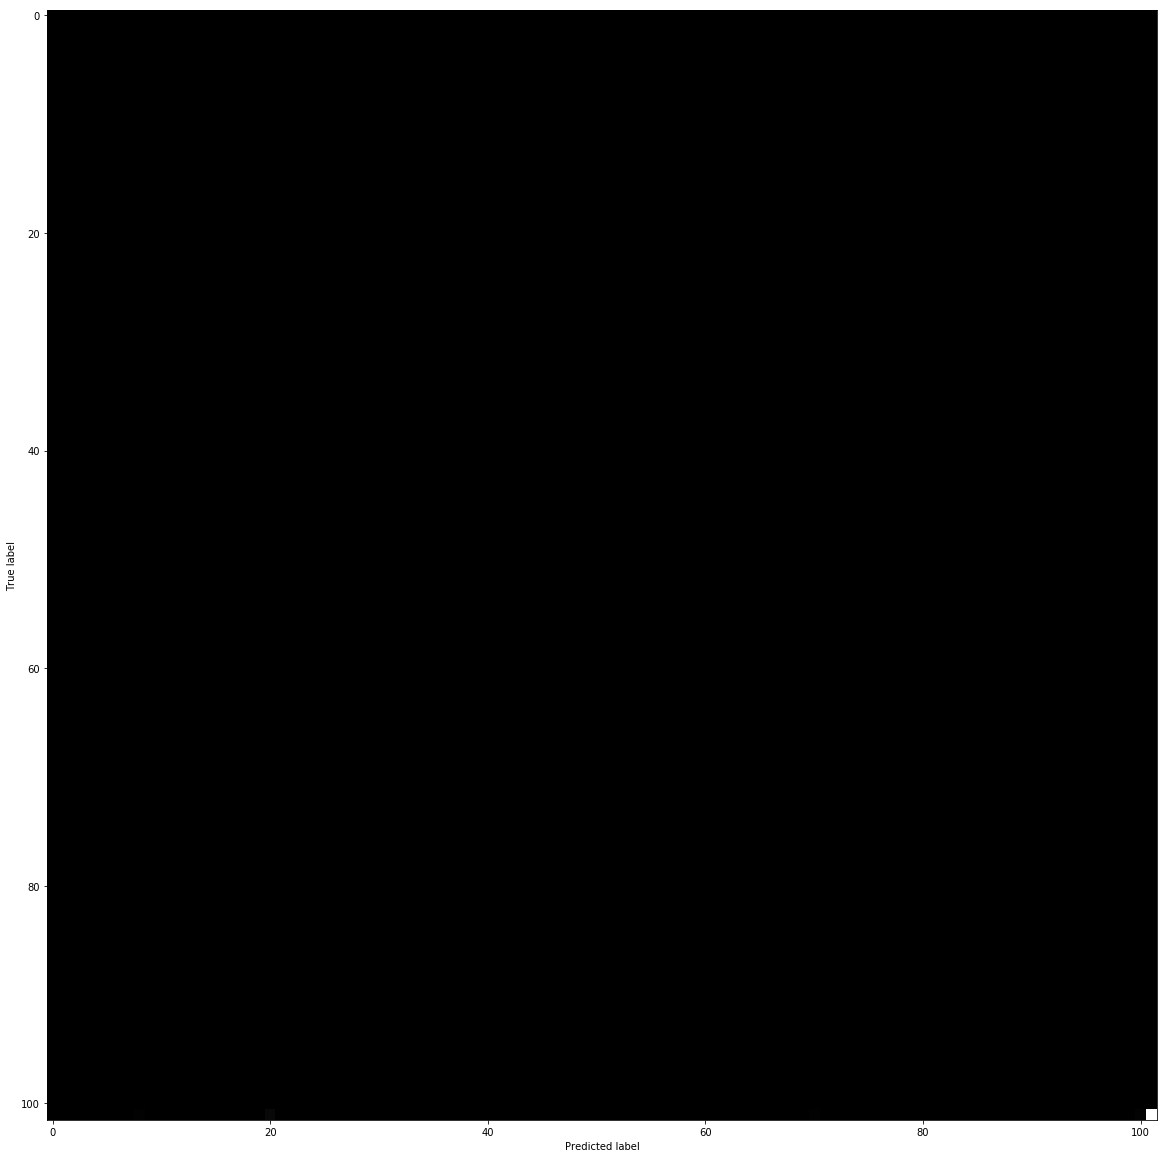

In [8]:
if SPEAKER_ID is not None:        
    print("Attack accuracy {0:.2f}%".format(100*accuracy / (N_ATTACKS * SAMPLES_PER_ATTACK)))
    cm = confusion_matrix(y_true=[SPEAKER_ID]*len(predictions), y_pred=predictions, labels=np.arange(0, N_CLASSES))
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.imshow(cm, interpolation='nearest', cmap='gray')
    tick_marks = np.arange(N_CLASSES)
    plt.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
else:
    predictions = np.array(predictions).flatten()
    _ = plt.hist(predictions, bins=102)    
    print("Attack accuracy {0:.2f}%".format(100*np.sum(predictions < 50) / float(len(predictions))))